In [3]:
import pandas as pd
import numpy as np
from process_game_state import ProcessGameState
from matplotlib import path
import seaborn as sns
from matplotlib import pyplot as plt
import math

In [4]:
# Convert from parquet to df
df = pd.read_parquet('game_state_frame_data.parquet', engine='pyarrow')

retract_col_name = "inventory"
retract_key_name = 'weapon_class'
players_cols = ['Player5', 'Player6', 'Player7', 'Player8', 'Player9']

df['extracted_feature_map'] = ProcessGameState.extract_feature(
    df, retract_col_name, retract_key_name)

polygon = path.Path(
    [(-1735, 250), (-2024, 398), (-2806, 742), (-2472, 1233), (-1565, 580)])
z_boundary = [285, 421]

df['is_in_region'] = df.apply(
    ProcessGameState.check_is_in_region, args=(polygon, z_boundary), axis=1)


In [5]:
# Q2(a)
# Rounds of Team 2 on T side and enters the region / Rounds of Team 2 on T side
team_2_on_t_side_in_region_rounds = df.loc[(
    df['is_in_region'] == True) & (df['side'] == 'T') & (df['team'] == 'Team2')]['round_num'].drop_duplicates()
team_2_on_t_side = df.loc[(df['side'] == 'T') & (
    df['team'] == 'Team2')]['round_num'].drop_duplicates()

ratio = len(team_2_on_t_side_in_region_rounds) / len(team_2_on_t_side)
print(ratio)

0.06666666666666667


In [11]:
# Q2(b)
# need to pivot wider:
# 1. Find the time that all of them are in bombsiteB
# 2. Filter the rows with required weapons
def has_required_weapons(df, weapon1, weapon2, target, players):
    count = 0
    for player in players:
        if type(df[player]) == dict:
            if df[player] is None:
                continue
            if weapon1 in df[player]:
                count = count + df[player][weapon1]

            if weapon2 in df[player]:
                count = count + df[player][weapon2]
    if count >= target:
        return True
    else:
        return False


condition = (df['area_name'] == 'BombsiteB') & (
    df['side'] == 'T') & (df['team'] == 'Team2')
filtered_df = df.loc[condition]
pivot_df = filtered_df.pivot(index="tick", columns="player")

pivot_df['has_required_weapons'] = pivot_df['extracted_feature_map'].apply(
    has_required_weapons, args=('Rifle', 'SMG', 2, players_cols), axis=1)

print(pivot_df.loc[pivot_df['has_required_weapons']
      == True]['clock_time'])
# We see that the first timer with required condition is 01:26
# Since the round of all these ticks are in round 28, the average timer will be 01:26
print(pivot_df.loc[pivot_df['has_required_weapons']
      == True]['round_num'])

player Player5 Player6 Player7 Player8 Player9
tick                                          
482748     NaN   01:26     NaN   01:26     NaN
482764     NaN   01:26     NaN   01:26     NaN
482780     NaN   01:26     NaN   01:26     NaN
482796     NaN   01:26     NaN   01:26     NaN
482812     NaN   01:26     NaN   01:26     NaN
483148   01:23   01:23     NaN   01:23     NaN
483260   01:22   01:22     NaN   01:22     NaN
483276   01:22   01:22     NaN   01:22     NaN
483292   01:22   01:22     NaN   01:22     NaN
483308   01:22   01:22     NaN   01:22     NaN
483324   01:22   01:22   01:22   01:22     NaN
483340   01:22   01:22   01:22   01:22     NaN
483420   01:21   01:21   01:21   01:21     NaN
483436   01:21   01:21   01:21   01:21     NaN
483452   01:21   01:21   01:21   01:21     NaN
483468   01:21   01:21   01:21   01:21     NaN
483484   01:21   01:21   01:21   01:21     NaN
483500   01:21   01:21   01:21   01:21     NaN
483516   01:20   01:20   01:20   01:20     NaN
484028   01:1

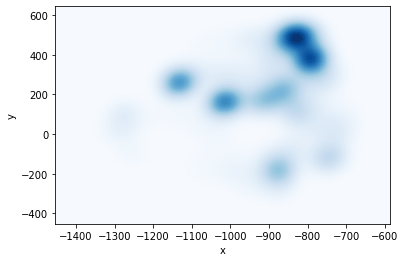

In [10]:
# Q2(c)
CT_condition = (df['area_name'] == 'BombsiteB') & (
    df['side'] == 'CT') & (df['team'] == 'Team2')
ax = sns.kdeplot(data=df.loc[CT_condition], x='x', y='y', fill=True,
                 thresh=0, levels=100, cmap="Blues")
plt.show()
fig = ax.get_figure()

I think we can set up a GitHub Action script. In this way, as long as the stakeholders upload the data to github, the ETL and other functions will be called. We can even use webhook so that when the results are generated, they will be forwarded to slack channel? Or maybe you can create a monitoring dashboard